In [19]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torch.utils.data import Dataset
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import VisionDataset
from PIL import Image
import os.path
import sys

In [20]:
#Batch Size 
batch_size = 128
image_size = 64
workers = 2

numchannels = 3 #Number of channels 
latent = 100 #Latent Space Size 
gen_feat = 64 # Size of feature maps in generator 
dis_feat = 64 # Size of feature maps in discriminator 

# Number of gpus available. Use 0 for cpu.
num_gpu = 1 

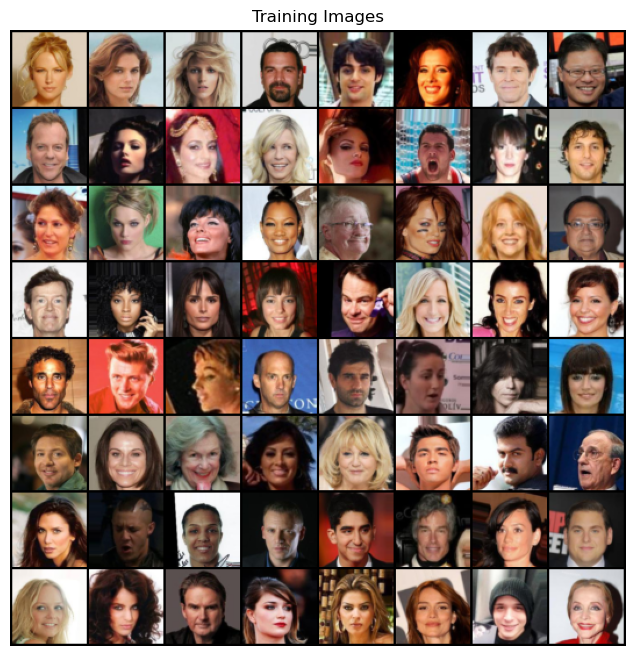

In [21]:
#Impliment data transforms and loading

#TODO
dataroot = r"C:\Users\prakh\Desktop\CMU_EDU\Sem2\24789\hw2\24789_HW2_S23\img_align_celeba2"
transform = transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])

dataset = dset.ImageFolder(root = dataroot, transform = transform)

# Create the dataloader
#TODO
dataloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, shuffle = True, num_workers = workers)#Add dataloader

#Select device
device = torch.device("cuda:0" if (torch.cuda.is_available() and num_gpu > 0) else "cpu")

#Display real images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [22]:
#Weight initialization for Generator and Discriminator no changes required 
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [23]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, num_gpu):
        super(Generator, self).__init__()
        self.num_gpu = num_gpu
        self.gen_feat = 64 # Number of features in the generator's first layer
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(latent, self.gen_feat * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(self.gen_feat * 8),
            nn.ReLU(True),
            # state size. (self.gen_feat*8) x 4 x 4
            nn.ConvTranspose2d(self.gen_feat * 8, self.gen_feat * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.gen_feat * 4),
            nn.ReLU(True),
            # state size. (self.gen_feat*4) x 8 x 8
            nn.ConvTranspose2d(self.gen_feat * 4, self.gen_feat * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.gen_feat * 2),
            nn.ReLU(True),
            # state size. (self.gen_feat*2) x 16 x 16
            nn.ConvTranspose2d(self.gen_feat * 2, self.gen_feat, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.gen_feat),
            nn.ReLU(True),
            # state size. (self.gen_feat) x 32 x 32
            nn.ConvTranspose2d(self.gen_feat, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. 3 x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [24]:
# Create the generator
netG = Generator(num_gpu).to(device)

#Device selection
if (device.type == 'cuda') and (num_gpu > 1):
    netG = nn.DataParallel(netG, list(range(num_gpu)))

netG.apply(weights_init)

print(netG)
print(device.type)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [25]:
class Discriminator(nn.Module):
    def __init__(self, num_gpu):
        super(Discriminator, self).__init__()
        self.num_gpu = num_gpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(numchannels, dis_feat, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(dis_feat, dis_feat * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(dis_feat * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(dis_feat * 2, dis_feat * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(dis_feat * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(dis_feat * 4, dis_feat* 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(dis_feat * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(dis_feat * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [26]:
# Create the Discriminator
netD = Discriminator(num_gpu).to(device)

#Device Selection
if (device.type == 'cuda') and (num_gpu > 1):
    netD = nn.DataParallel(netD, list(range(num_gpu)))

netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [27]:
#Select Loss Function
#TODO
criterion = nn.BCELoss()

fixed_noise = torch.randn(64, latent, 1, 1, device=device)

#Real and fake labels for training
real_label = 1.
fake_label = 0.

# Training Parameters
num_epochs = 15 
lr = 0.0003
beta1 = 0.5

# Setup optimizers for Generator and Discriminator 
#TODO
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [28]:
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ## Train with all-real batch
        
        #Train Discriminator
        #TODO 
        netD.zero_grad()
        
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        
        # Forward pass real batch through D
#         output = netD(real_cpu.unsqueeze(0)).view(-1)
        output = netD(real_cpu).view(-1)     ###############
        
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()
        
        ## Train with all-fake batch

        # Generate fake images 
        noise = torch.randn(b_size, latent, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        
        # Update Discriminator
        optimizerD.step()
        
        #Train Generator
        #TODO
        
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        
        # Update Generator
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        #Record Losses to Plot
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/15][0/389]	Loss_D: 2.5660	Loss_G: 3.8671	D(x): 0.2073	D(G(z)): 0.4325 / 0.0299
[0/15][50/389]	Loss_D: 0.3179	Loss_G: 7.4473	D(x): 0.9011	D(G(z)): 0.0021 / 0.0018
[0/15][100/389]	Loss_D: 1.5158	Loss_G: 11.6296	D(x): 0.8561	D(G(z)): 0.6487 / 0.0001
[0/15][150/389]	Loss_D: 0.8335	Loss_G: 6.3110	D(x): 0.8398	D(G(z)): 0.4373 / 0.0033
[0/15][200/389]	Loss_D: 0.7855	Loss_G: 3.7343	D(x): 0.6899	D(G(z)): 0.2370 / 0.0370
[0/15][250/389]	Loss_D: 0.6641	Loss_G: 3.6174	D(x): 0.7062	D(G(z)): 0.2017 / 0.0485
[0/15][300/389]	Loss_D: 0.7006	Loss_G: 4.6535	D(x): 0.8725	D(G(z)): 0.3720 / 0.0238
[0/15][350/389]	Loss_D: 0.9789	Loss_G: 4.2738	D(x): 0.7708	D(G(z)): 0.4347 / 0.0285
[1/15][0/389]	Loss_D: 1.2387	Loss_G: 6.2070	D(x): 0.8835	D(G(z)): 0.5497 / 0.0075
[1/15][50/389]	Loss_D: 1.7504	Loss_G: 1.8717	D(x): 0.3123	D(G(z)): 0.0065 / 0.2728
[1/15][100/389]	Loss_D: 0.9554	Loss_G: 4.4097	D(x): 0.8959	D(G(z)): 0.4922 / 0.0195
[1/15][150/389]	Loss_D: 1.1627	Loss_G: 5.5481	D(x): 0.8

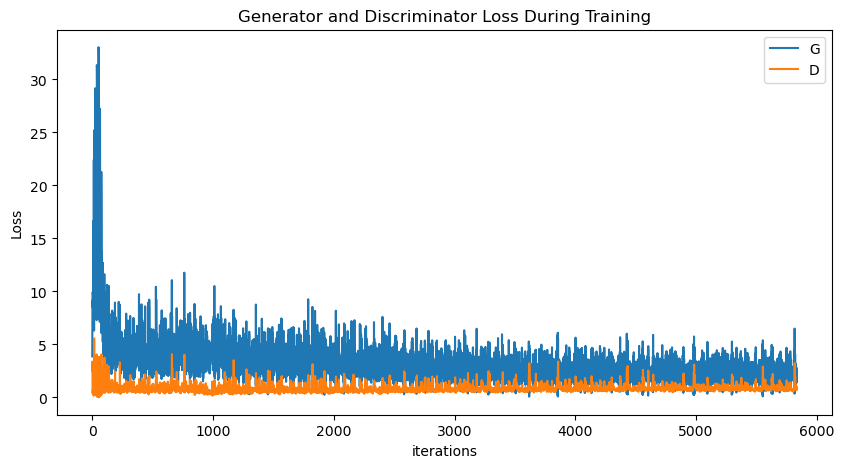

In [29]:
#Plot Your Generator and Discriminator Loss
#No Changes Needed
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

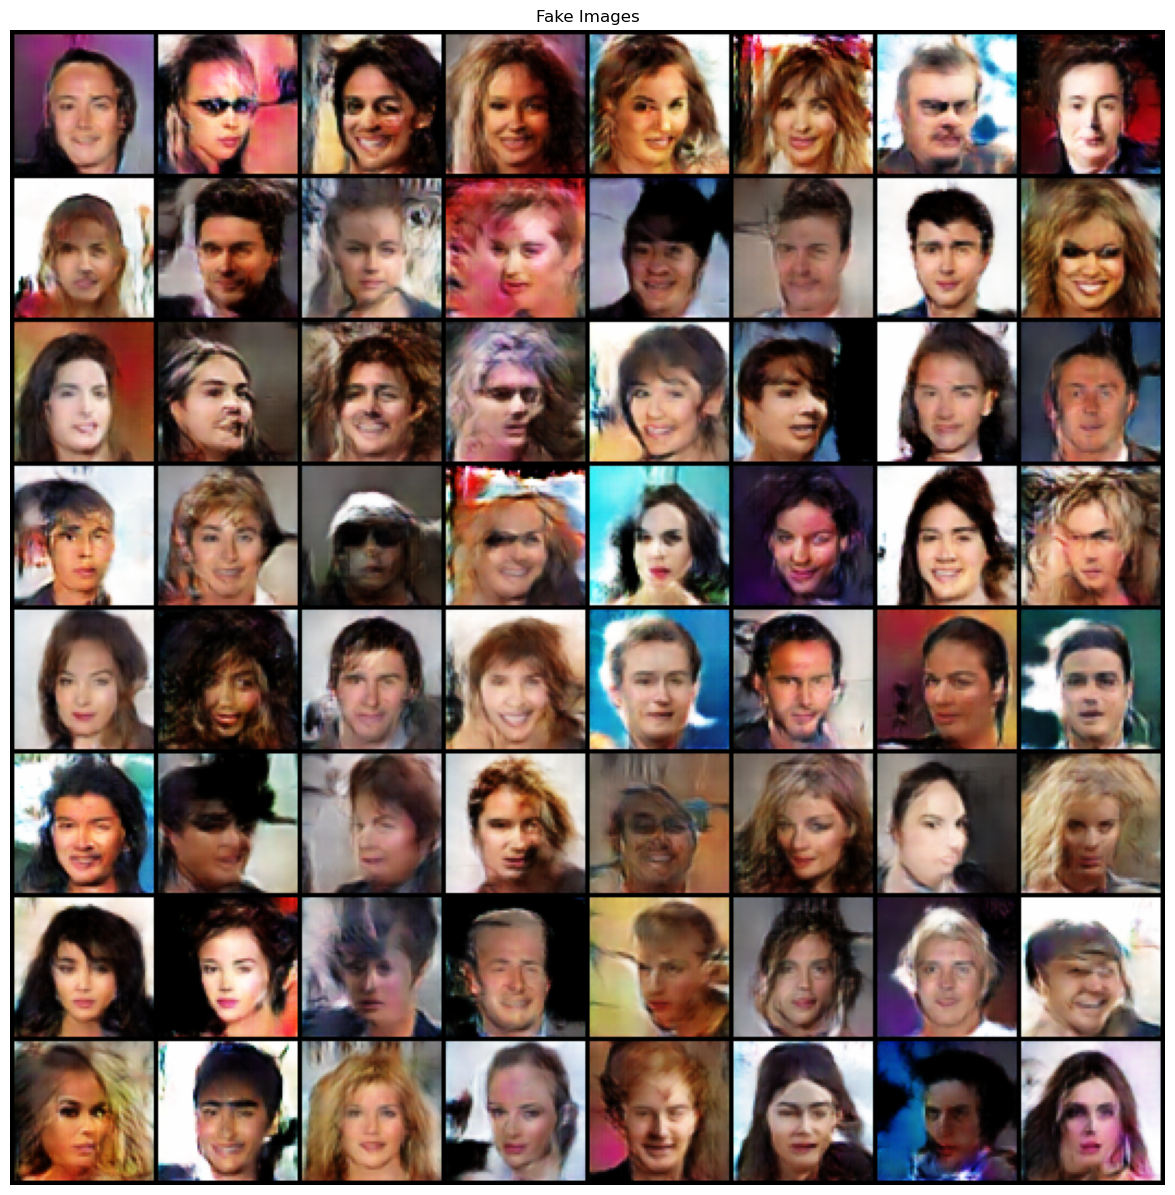

In [30]:
# Fake Images Grid 
#No Changes Needed
plt.figure(figsize=(15,15))
plt.subplot(1,1,1)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()